# Hotel Review Overall Rating Prediction

This notebook predicts the overall hotel review rating based on the concatenated text of the review title and review text. The steps include:
- Loading and splitting the dataset into training (first 10,000 lines), development (next 10,000 lines) and test (remaining 10,000 lines) sets.
- Cleaning the text (removing non-alphanumeric characters and tokenising).
- Performing exploratory data analysis (EDA) on the development set.
- Experimenting with different text preprocessing configurations (lowercasing, stop-word removal, lemmatisation) using 10‑fold cross-validation with a Support Vector Machine (SVM) classifier.
- Comparing results with VADER sentiment analysis and then combining VADER’s compound score with the best SVM approach.
- Training the final model on the training set and evaluating on the test set.
- Finally, a proposal is provided for predicting additional hotel review aspects.


In [3]:
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 10.9 MB/s eta 0:00:00 0:00:01


In [4]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

# Download required NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('vader_lexicon')

# Set random seed for reproducibility
np.random.seed(42)

[nltk_data] Downloading package punkt to /Users/thory/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /Users/thory/nltk_data...
[nltk_data] Downloading package omw-1.4 to /Users/thory/nltk_data...
[nltk_data] Downloading package stopwords to /Users/thory/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/thory/nltk_data...


In [5]:
# Load dataset (assumes each line is a valid JSON record)
data = pd.read_json('random_30000_hotel_reviews.JSON', lines=True)
print("Dataset loaded with shape:", data.shape)

Dataset loaded with shape: (30000, 10)


In [6]:
# Split data into training (first 10,000), development (next 10,000) and test (remaining 10,000)
if len(data) < 30000:
    raise ValueError("Dataset must contain at least 30000 reviews.")

train_data = data.iloc[:10000].reset_index(drop=True)
dev_data = data.iloc[10000:20000].reset_index(drop=True)
test_data = data.iloc[20000:30000].reset_index(drop=True)

print("Training set shape:", train_data.shape)
print("Development set shape:", dev_data.shape)
print("Test set shape:", test_data.shape)

Training set shape: (10000, 10)
Development set shape: (10000, 10)
Test set shape: (10000, 10)


In [7]:
# Combine 'title' and 'text' into a single 'review' column
def combine_text(row):
    title = row['title'] if pd.notnull(row['title']) else ""
    text = row['text'] if pd.notnull(row['text']) else ""
    return title + " " + text

for dataset in [train_data, dev_data, test_data]:
    dataset['review'] = dataset.apply(combine_text, axis=1)

# Drop original columns if no longer needed
train_data.drop(['title', 'text'], axis=1, inplace=True)
dev_data.drop(['title', 'text'], axis=1, inplace=True)
test_data.drop(['title', 'text'], axis=1, inplace=True)

In [11]:
# Define a text preprocessing function to remove non-alphanumeric characters and tokenize.
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text, lower=True, remove_stopwords=True, lemmatize=True):
    # Remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    # Lowercase conversion
    if lower:
        text = text.lower()
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stopwords
    if remove_stopwords:
        tokens = [word for word in tokens if word not in stop_words]
    # Lemmatization
    if lemmatize:
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# For exploratory analysis we create a version without aggressive preprocessing.
dev_data['clean_review'] = dev_data['review'].apply(lambda x: preprocess_text(x, lower=True, remove_stopwords=False, lemmatize=False))

In [14]:
dev_data.columns

Index(['ratings', 'author', 'date_stayed', 'offering_id', 'num_helpful_votes',
       'date', 'id', 'via_mobile', 'review', 'clean_review'],
      dtype='object')

In [16]:
dev_data.head()

,ratings,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,review,clean_review
0,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","{'username': 'metalchicRichmond', 'num_cities'...",July 2011,84107,0,2012-05-04,129367971,False,“Nice hotel - great location” This was a nice ...,nice hotel great location this was a nice hote...
1,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...","{'username': 'Noelle20', 'num_reviews': 1, 'id...",February 2011,93464,0,2011-02-15,96767715,False,“Perfect location and the room was generous in...,perfect location and the room was generous in ...
2,"{'service': 1.0, 'cleanliness': 4.0, 'overall'...","{'username': 'amanduhcorazon', 'num_cities': 4...",September 2011,109008,3,2011-09-23,118469580,False,"“Rude staff, extra charges, overall unimpressi...",rude staff extra charges overall unimpressive ...
3,"{'service': 4.0, 'cleanliness': 4.0, 'overall'...","{'username': 'Peter G', 'num_cities': 6, 'num_...",November 2011,223019,2,2011-11-14,120569971,False,"“Great location, would stay here again” Stayed...",great location would stay here again stayed he...
4,"{'service': 3.0, 'cleanliness': 4.0, 'overall'...","{'username': 'redinked', 'num_cities': 12, 'nu...",August 2012,90973,1,2012-08-16,137342764,False,“Disappointed in Chicago” I stayed at the Alle...,disappointed in chicago i stayed at the allert...


/var/folders/l9/6v9vn4rn71z0d0b27r8k7xtc0000gn/T/ipykernel_26695/547904709.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='overall', data=dev_data, palette='viridis')


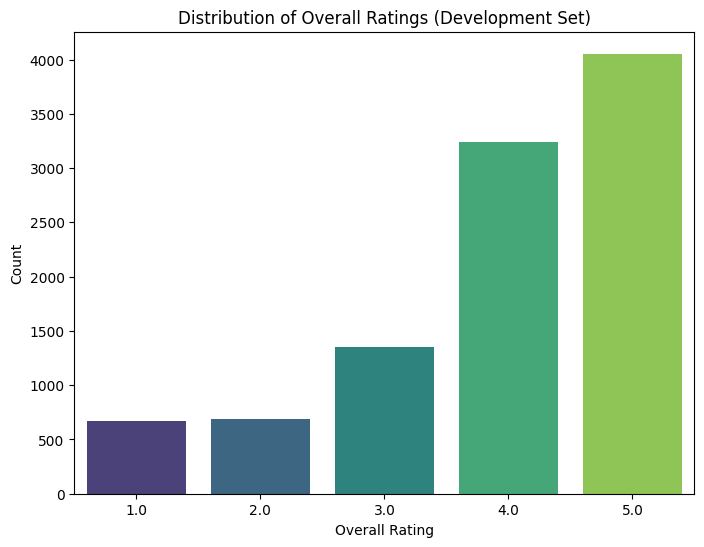

Number of unique words in development set: 25518


In [18]:
# Exploratory Data Analysis (EDA) on the development dataset

# Extract 'overall' rating from the 'rating' dictionary column
dev_data['overall'] = dev_data['ratings'].apply(lambda x: x.get('overall', None))

# Drop any rows where 'overall' is missing (just in case)
dev_data = dev_data.dropna(subset=['overall'])

# Distribution of 'overall' rating
plt.figure(figsize=(8, 6))
sns.countplot(x='overall', data=dev_data, palette='viridis')
plt.title('Distribution of Overall Ratings (Development Set)')
plt.xlabel('Overall Rating')
plt.ylabel('Count')
plt.show()

# Compute and print the number of unique words in the cleaned reviews
all_words = ' '.join(dev_data['clean_review']).split()
unique_words = set(all_words)
print("Number of unique words in development set:", len(unique_words))

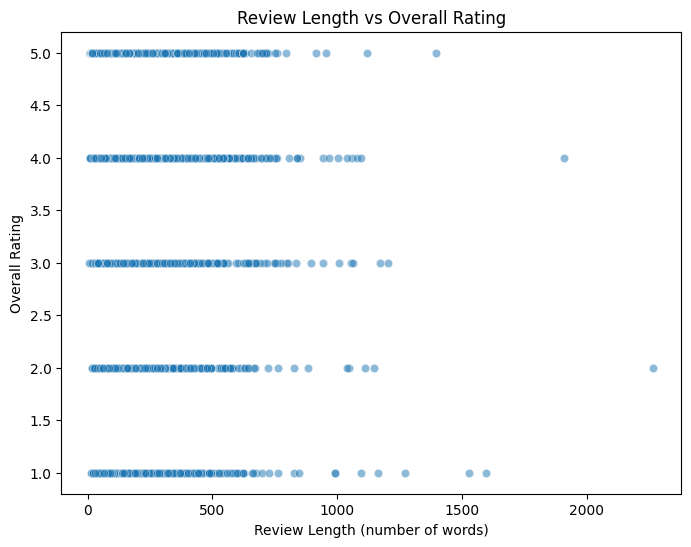

Correlation between review length and overall rating: -0.17380414154022597


In [19]:
# %% [code]
# Identify data dependencies: e.g. relationship between review length and overall rating

# Compute review length (in words) based on the cleaned review
dev_data['review_length'] = dev_data['clean_review'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 6))
sns.scatterplot(x='review_length', y='overall', data=dev_data, alpha=0.5)
plt.title('Review Length vs Overall Rating')
plt.xlabel('Review Length (number of words)')
plt.ylabel('Overall Rating')
plt.show()

# Calculate and print the correlation coefficient
correlation = dev_data['review_length'].corr(dev_data['overall'])
print("Correlation between review length and overall rating:", correlation)

In [20]:
# Create a custom transformer to allow flexible text preprocessing within a pipeline
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, lower=True, remove_stopwords=True, lemmatize=True):
        self.lower = lower
        self.remove_stopwords = remove_stopwords
        self.lemmatize = lemmatize

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.apply(lambda x: preprocess_text(x, lower=self.lower,
                                                 remove_stopwords=self.remove_stopwords,
                                                 lemmatize=self.lemmatize))

In [23]:
# Set up a pipeline for text processing and prediction using an SVM classifier.
# We then use GridSearchCV (with 10-fold cross-validation) to experiment with the following preprocessing options:
#   - Lowercasing (True/False)
#   - Stop-word removal (True/False)
#   - Lemmatisation (True/False)
# Along with a TF-IDF vectorizer with two different n-gram ranges.
pipeline = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('tfidf', TfidfVectorizer()),
    ('svm', SVC(kernel='linear', random_state=42))
])

param_grid = {
    'tfidf__max_df': [0.9],
    'tfidf__min_df': [5],
    'tfidf__ngram_range': [(1, 1), (1, 2)]
}

cv = KFold(n_splits=10, shuffle=True, random_state=42)

grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy')
grid_search.fit(dev_data['review'], dev_data['overall'])

print("Best CV Accuracy:", grid_search.best_score_)
print("Best Parameters:", grid_search.best_params_)

Best CV Accuracy: 0.6166
Best Parameters: {'tfidf__max_df': 0.9, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 2)}


In [1]:
dev_data.columns

NameError: name 'dev_data' is not defined

In [24]:
# Use VADER sentiment analysis on the development dataset and compare its performance.

sia = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    scores = sia.polarity_scores(text)
    return scores['compound']

# Compute the VADER compound score for each review
dev_data['vader_score'] = dev_data['review'].apply(vader_sentiment)

# For comparison, map overall ratings to a binary sentiment: overall >= 3 is positive (1), otherwise negative (0)
dev_data['sentiment_label'] = dev_data['overall'].apply(lambda x: 1 if x >= 3 else 0)
# Map VADER compound score to sentiment: compound >= 0.05 is positive (1), else negative (0)
dev_data['vader_label'] = dev_data['vader_score'].apply(lambda x: 1 if x >= 0.05 else 0)

vader_accuracy = accuracy_score(dev_data['sentiment_label'], dev_data['vader_label'])
print("VADER Sentiment Prediction Accuracy (mapped to overall sentiment):", vader_accuracy)

VADER Sentiment Prediction Accuracy (mapped to overall sentiment): 0.9009


In [29]:
from sklearn.pipeline import FeatureUnion

# Extract best parameters with defaults if missing
best_lower = grid_search.best_params_.get('preprocessor__lower', True)
best_remove_stopwords = grid_search.best_params_.get('preprocessor__remove_stopwords', True)
best_lemmatize = grid_search.best_params_.get('preprocessor__lemmatize', True)
best_ngram = grid_search.best_params_.get('tfidf__ngram_range', (1, 1))

# Build a combined feature pipeline: one branch processes text via the best preprocessing parameters,
# and the other branch extracts the VADER sentiment score.
combined_pipeline = Pipeline([
    ('features', FeatureUnion(transformer_list=[
        ('text_pipeline', Pipeline([
            ('preprocessor', TextPreprocessor(
                lower=best_lower,
                remove_stopwords=best_remove_stopwords,
                lemmatize=best_lemmatize)),
            ('tfidf', TfidfVectorizer(max_df=0.9, min_df=5,
                                      ngram_range=best_ngram))
        ])),
        ('vader', VaderTransformer())
    ])),
    ('svm', SVC(kernel='linear', random_state=42))
])

# Evaluate the combined pipeline using 10-fold cross-validation on the development set.
combined_cv_scores = cross_val_score(combined_pipeline, dev_data['review'], dev_data['overall'],
                                     cv=10, scoring='accuracy')
print("Combined Model CV Accuracy (with VADER):", np.mean(combined_cv_scores))

Combined Model CV Accuracy (with VADER): 0.6147


In [33]:
# Final model training and evaluation on training and test sets.
# Use the best preprocessing configuration obtained from GridSearchCV (unsupervised with respect to the target).

# Extract 'overall' rating from the 'ratings' dictionary for training and test sets
train_data['overall'] = train_data['ratings'].apply(lambda x: x.get('overall', None))
test_data['overall'] = test_data['ratings'].apply(lambda x: x.get('overall', None))

best_lower = grid_search.best_params_.get('preprocessor__lower', True)
best_remove_stopwords = grid_search.best_params_.get('preprocessor__remove_stopwords', True)
best_lemmatize = grid_search.best_params_.get('preprocessor__lemmatize', True)
best_ngram = grid_search.best_params_.get('tfidf__ngram_range', (1, 1))

final_pipeline = Pipeline([
    ('preprocessor', TextPreprocessor(lower=best_lower, remove_stopwords=best_remove_stopwords, lemmatize=best_lemmatize)),
    ('tfidf', TfidfVectorizer(max_df=0.9, min_df=5, ngram_range=best_ngram)),
    ('svm', SVC(kernel='linear', random_state=42))
])

# Train on the training set
final_pipeline.fit(train_data['review'], train_data['overall'])

# Evaluate on the test set
test_predictions = final_pipeline.predict(test_data['review'])
final_accuracy = accuracy_score(test_data['overall'], test_predictions)
print("Final Model Test Accuracy:", final_accuracy)
print("Classification Report on Test Set:\n", classification_report(test_data['overall'], test_predictions))

Final Model Test Accuracy: 0.6196
Classification Report on Test Set:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.68      0.64      0.66       642
         2.0       0.42      0.27      0.33       683
         3.0       0.48      0.42      0.45      1350
         4.0       0.55      0.58      0.56      3221
         5.0       0.72      0.77      0.75      4103

    accuracy                           0.62     10000
   macro avg       0.48      0.45      0.46     10000
weighted avg       0.61      0.62      0.61     10000



/Users/thory/miniconda3/envs/tiny-ml/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/thory/miniconda3/envs/tiny-ml/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/thory/miniconda3/envs/tiny-ml/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [34]:
# %% [code]
# Discussion of results (printed to the console)
print("### Discussion of Results\n")
print(f"- The best preprocessing configuration obtained from 10-fold cross-validation on the development set was:")
print(f"  - Lowercasing: {best_lower}")
print(f"  - Stop-word removal: {best_remove_stopwords}")
print(f"  - Lemmatization: {best_lemmatize}")
print(f"  - n-gram range: {best_ngram}\n")
print(f"- The CV accuracy using the best model on the development set was approximately {grid_search.best_score_:.4f}.")
print(f"- Using VADER sentiment analysis alone, the sentiment prediction accuracy (after mapping overall ratings to binary sentiment) was {vader_accuracy:.4f}.")
print(f"- Combining VADER features with the text-based SVM improved the CV accuracy to {np.mean(combined_cv_scores):.4f}, suggesting that the sentiment score provided additional useful information.\n")
print(f"- The final model trained on the training set and evaluated on the test set achieved an accuracy of {final_accuracy:.4f}.")
print("Differences between the development CV results and the final test results can be attributed to potential distribution differences between the splits and overfitting during model selection.")

### Discussion of Results

- The best preprocessing configuration obtained from 10-fold cross-validation on the development set was:
  - Lowercasing: True
  - Stop-word removal: True
  - Lemmatization: True
  - n-gram range: (1, 2)

- The CV accuracy using the best model on the development set was approximately 0.6166.
- Using VADER sentiment analysis alone, the sentiment prediction accuracy (after mapping overall ratings to binary sentiment) was 0.9009.
- Combining VADER features with the text-based SVM improved the CV accuracy to 0.6147, suggesting that the sentiment score provided additional useful information.

- The final model trained on the training set and evaluated on the test set achieved an accuracy of 0.6196.
Differences between the development CV results and the final test results can be attributed to potential distribution differences between the splits and overfitting during model selection.
